In [1]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

import get_secrets

In [2]:
secrets = get_secrets.get_secrets('.secrets')
server = secrets[0]
username = secrets[1]
password = secrets[2]
database = secrets[3]
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [3]:
df = pd.read_sql(
    """
    select ticker, date, ret, roeq, bm, mom12m
    from data
    where date='2000-01'
    order by date, ticker
    """, 
    conn
)
df = df.dropna()
conn.close()

features = ["bm", "mom12m", "roeq"]
df = df.set_index(["date", "ticker"])

In [4]:
model = DecisionTreeRegressor(
  max_depth=2
)

Xtrain = df[features]
ytrain = df["ret"]
_ = model.fit(Xtrain, ytrain)

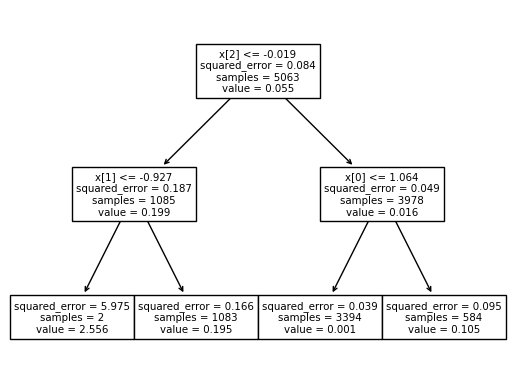

In [5]:
_ = plot_tree(model)

In [6]:
pd.Series(model.feature_importances_, index=features)

bm        0.119903
mom12m    0.247134
roeq      0.632963
dtype: float64

In [7]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

transform = make_column_transformer(
    (OneHotEncoder(), ["industry"]),
    remainder="passthrough"
)

qt = QuantileTransformer(output_distribution="normal")
poly = PolynomialFeatures(degree=2, include_bias=False)

In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
  max_depth=4,
  n_estimators=200
)

pipe = make_pipeline(
  transform,
  poly,
  model
)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
  max_depth=4,
  learning_rate=0.01,
  n_estimators=200,
)

pipe = make_pipeline(
  transform,
  poly,
  model
)

In [10]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        max_depth=4,
    ),
    learning_rate=0.05,
    n_estimators=200
)

pipe = make_pipeline(
  transform,
  poly,
  model
)

In [11]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=[4, 4]
)

pipe = make_pipeline(
  transform,
  poly,
  model
)